In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## import library

In [11]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS
from bs4 import BeautifulSoup
import re,string,unicodedata

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from xgboost.sklearn import XGBClassifier

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [39]:
data = pd.read_csv("/content/drive/MyDrive/Projek UAS/IMDB Dataset.csv")

In [37]:
data.head()

0    one review mention watch oz episod youll hook ...
1    wonder littl product film techniqu unassum old...
2    thought wonder way spend time hot summer weeke...
3    basic there famili littl boy jake think there ...
4    petter mattei love time money visual stun film...
Name: review, dtype: object

In [5]:
# menampilkan shape dari data kita
data.shape

(50000, 2)

## Preprocessing

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [7]:
# statistical summary of our data
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [13]:
import nltk
nltk.download('stopwords')
stop = stopwords.words('english')

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
wl = WordNetLemmatizer()

ps=nltk.porter.PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [40]:
#function to clean data
def clean_text(text,stemming = True):
    soup = BeautifulSoup(text, "html.parser") #remove html tags
    text = soup.get_text()
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'',text)
    text = re.sub(r'http\S+', '', text) #remove urls
    text = re.sub(r'\.(?=\S)', '. ',text) #add space after full stop
    text = "".join([word.lower() for word in text if word not in string.punctuation]) #remove punctuation
    #tokens = re.split('\W+', text) #create tokens
 #   if lemmatize:
  #      text = " ".join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()]) #lemmatize
    if stemming:
        text = " ".join([ps.stem(word)for word in text.split() if word not in stop and word.isalpha()])
    else:
        text = " ".join([word for word in text.split() if word not in stop and word.isalpha()]) 
    return text

In [41]:
data['review']=data['review'].apply(clean_text,stemming = True)

In [42]:
#converting target variable to numeric labels
data.sentiment = [ 1 if each == "positive" else 0 for each in data.sentiment]

In [43]:
#after converting labels
data.head()

,review,sentiment
0,one review mention watch oz episod youll hook ...,1
1,wonder littl product film techniqu unassum old...,1
2,thought wonder way spend time hot summer weeke...,1
3,basic there famili littl boy jake think there ...,0
4,petter mattei love time money visual stun film...,1


## EDA

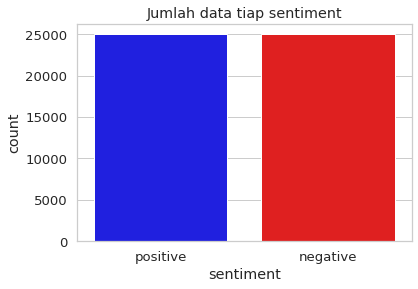

In [19]:
### Count Plot
sns.set(style = "whitegrid" , font_scale = 1.2)
sns.countplot(data.sentiment,palette = ['blue','red'],order = [1,0])
plt.xticks(ticks = np.arange(2),labels = ['positive','negative'])
plt.title('Jumlah data tiap sentiment')
plt.show()

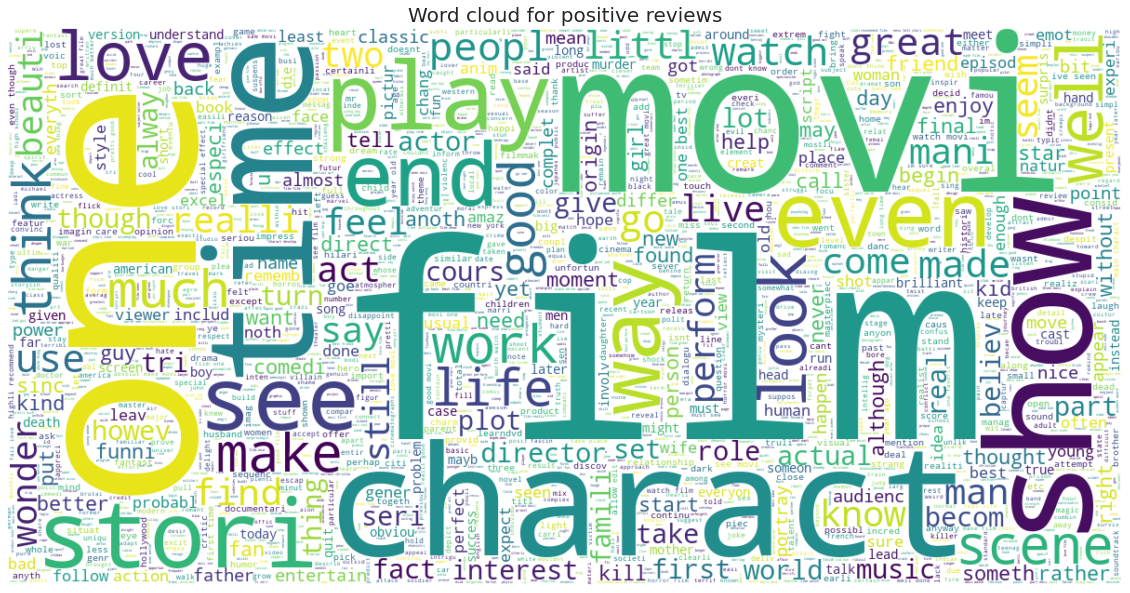

In [20]:
#word cloud for positive reviews
positive_data = data[data.sentiment == 1]['review']
positive_data_string = ' '.join(positive_data)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width=1200, height=600,background_color="white").generate(positive_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for positive reviews',fontsize = 20)
plt.show()

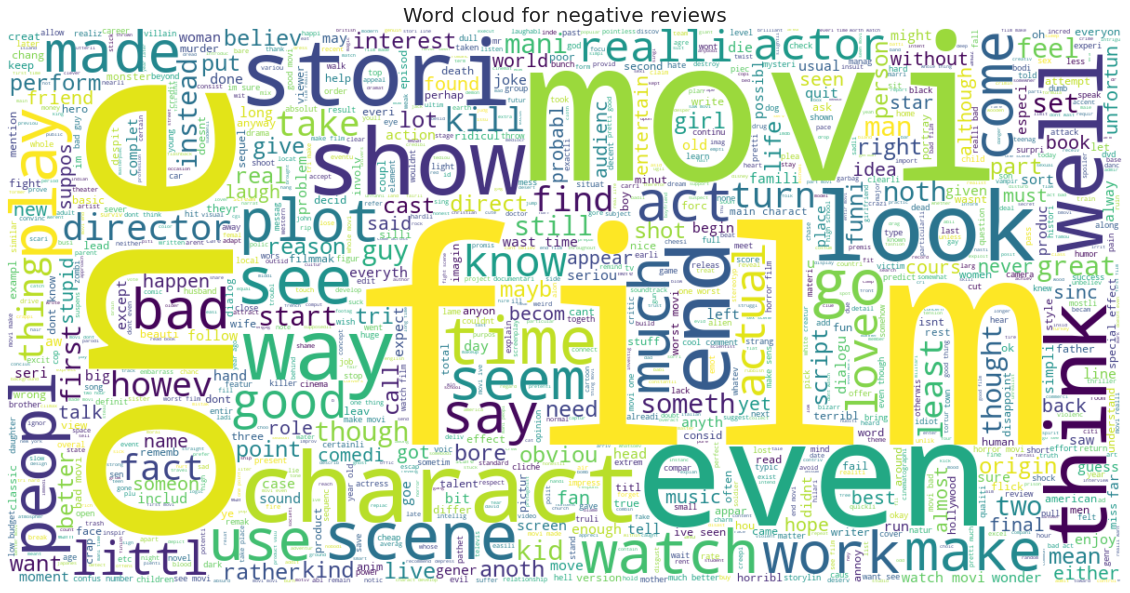

In [21]:
#word cloud for negative reviews
negative_data = data[data.sentiment == 0]['review']
negative_data_string = ' '.join(negative_data)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width=1200, height=600,background_color="white").generate(negative_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for negative reviews',fontsize = 20)
plt.show()

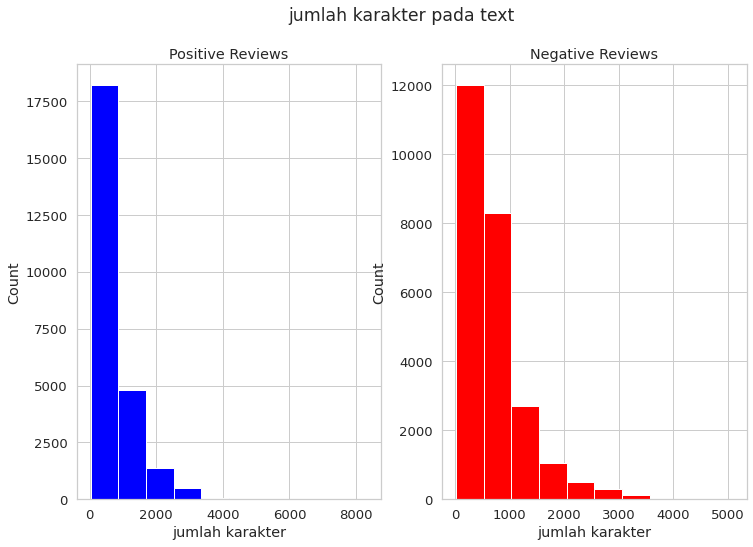

In [22]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=positive_data.str.len()
ax1.hist(text_len,color='blue')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('jumlah karakter')
ax1.set_ylabel('Count')
text_len=negative_data.str.len()
ax2.hist(text_len,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('jumlah karakter')
ax2.set_ylabel('Count')
fig.suptitle('jumlah karakter pada text')
plt.show()

In [26]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(data.review)
corpus[:5]

from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = pd.DataFrame(most_common,columns = ['corpus','countv'])
most_common

,corpus,countv
0,movi,101369
1,film,94140
2,one,53931
3,like,44144
4,time,30796
5,good,29421
6,make,28674
7,charact,28035
8,see,27867
9,get,27817


In [27]:
most_common = most_common.sort_values('countv')

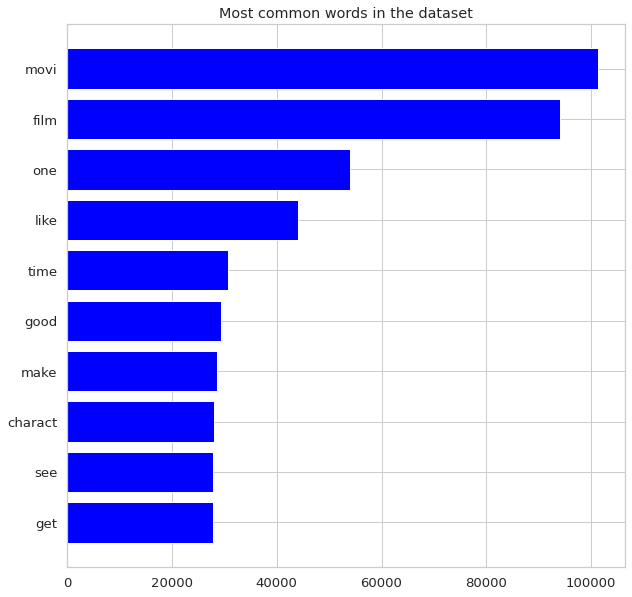

In [28]:
plt.figure(figsize =(10,10))
plt.yticks(range(len(most_common)), list(most_common.corpus))
plt.barh(range(len(most_common)), list(most_common.countv),align='center',color = 'blue')
plt.title('Most common words in the dataset')
plt.show()


In [29]:
def get_ngrams(review, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(review)
    bag_of_words = vec.transform(review) #sparse matrix of count_vectorizer
    sum_words = bag_of_words.sum(axis=0) #total number of words
    sum_words = np.array(sum_words)[0].tolist() #convert to list
    words_freq = [(word, sum_words[idx]) for word, idx in vec.vocabulary_.items()] #get word freqency for word location in count vec
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) #key is used to perform sorting using word_freqency 
    return words_freq[:n]

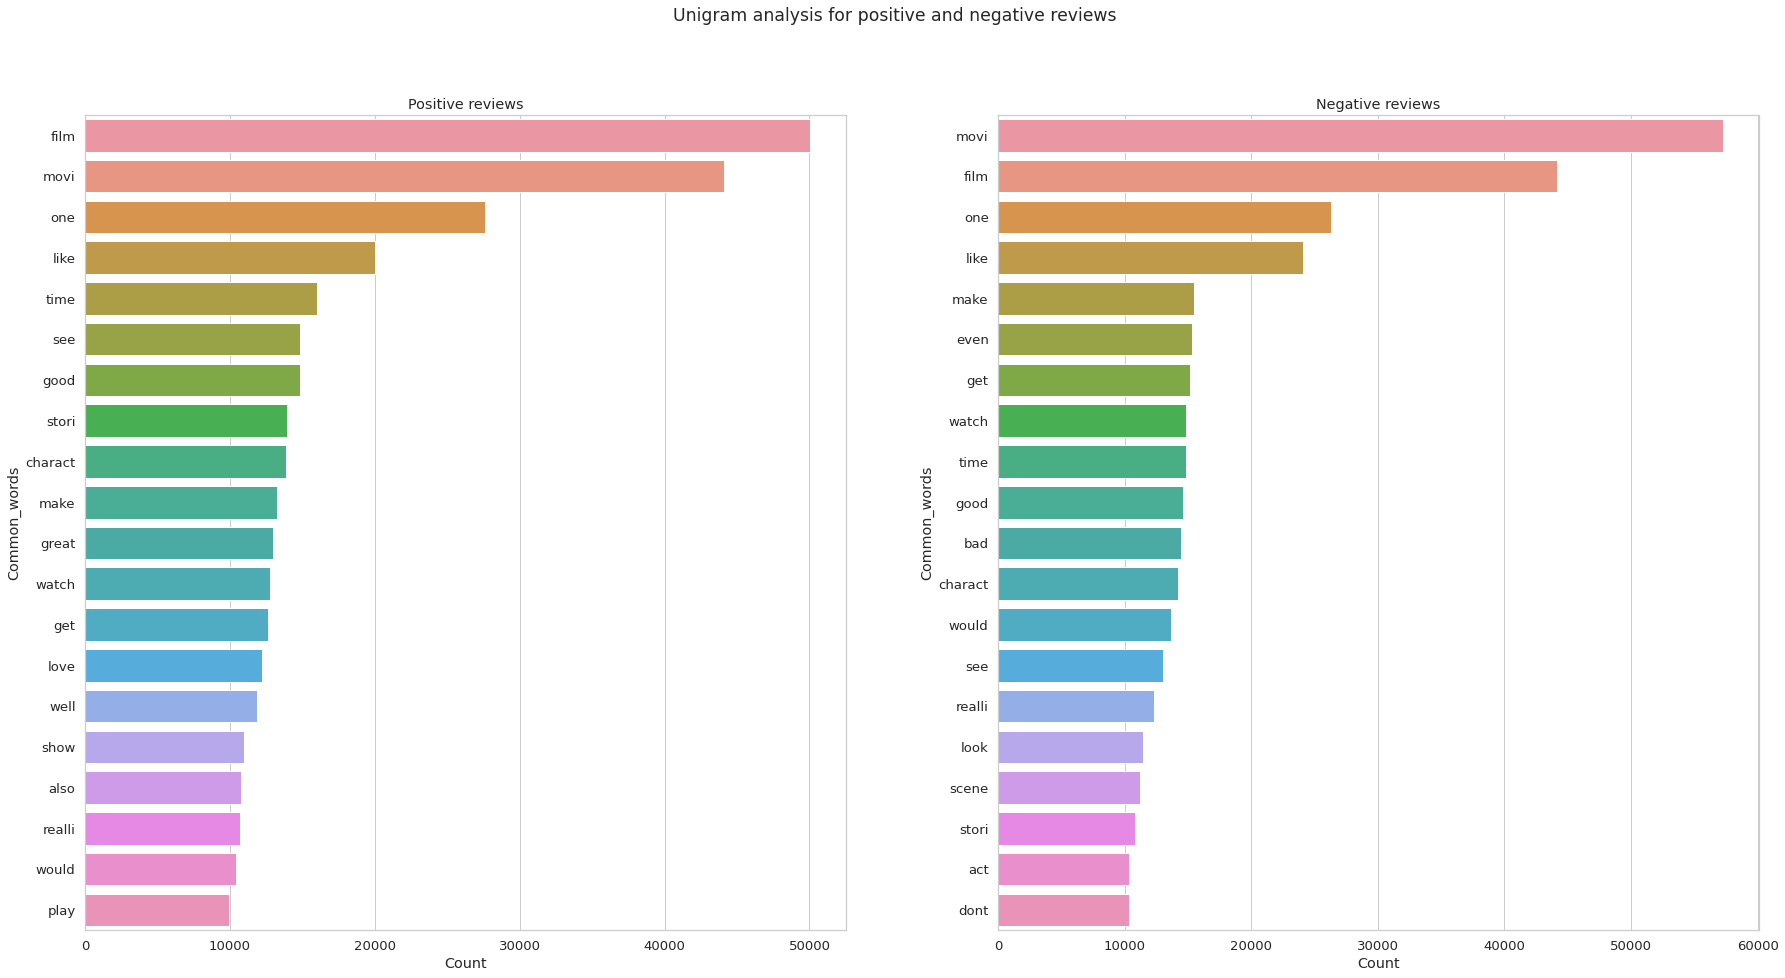

In [30]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(30,15))
uni_positive = get_ngrams(positive_data,20,1)
uni_positive = dict(uni_positive)
temp = pd.DataFrame(list(uni_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('Positive reviews')
uni_negative = get_ngrams(negative_data,20,1)
uni_negative = dict(uni_negative)
temp = pd.DataFrame(list(uni_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('Negative reviews')
fig.suptitle('Unigram analysis for positive and negative reviews')
plt.show()


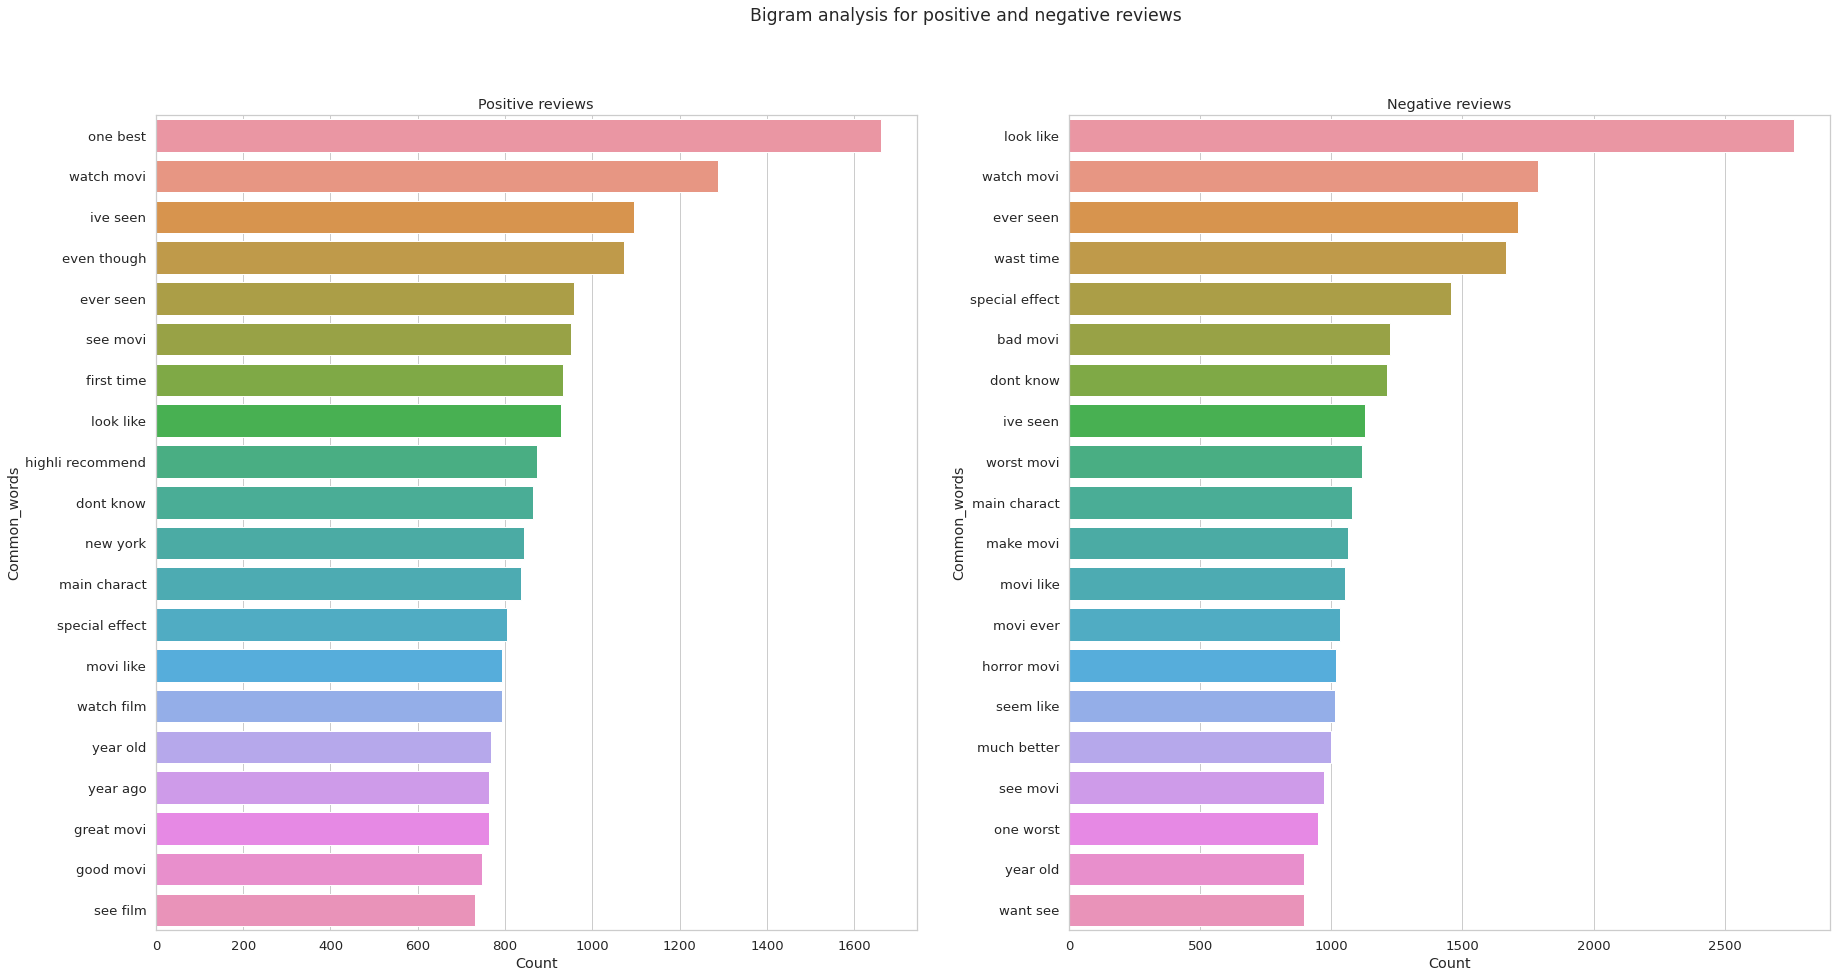

In [31]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(30,15))
bi_positive = get_ngrams(positive_data,20,2)
bi_positive = dict(bi_positive)
temp = pd.DataFrame(list(bi_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('Positive reviews')
bi_negative = get_ngrams(negative_data,20,2)
bi_negative = dict(bi_negative)
temp = pd.DataFrame(list(bi_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('Negative reviews')
fig.suptitle('Bigram analysis for positive and negative reviews')
plt.show()

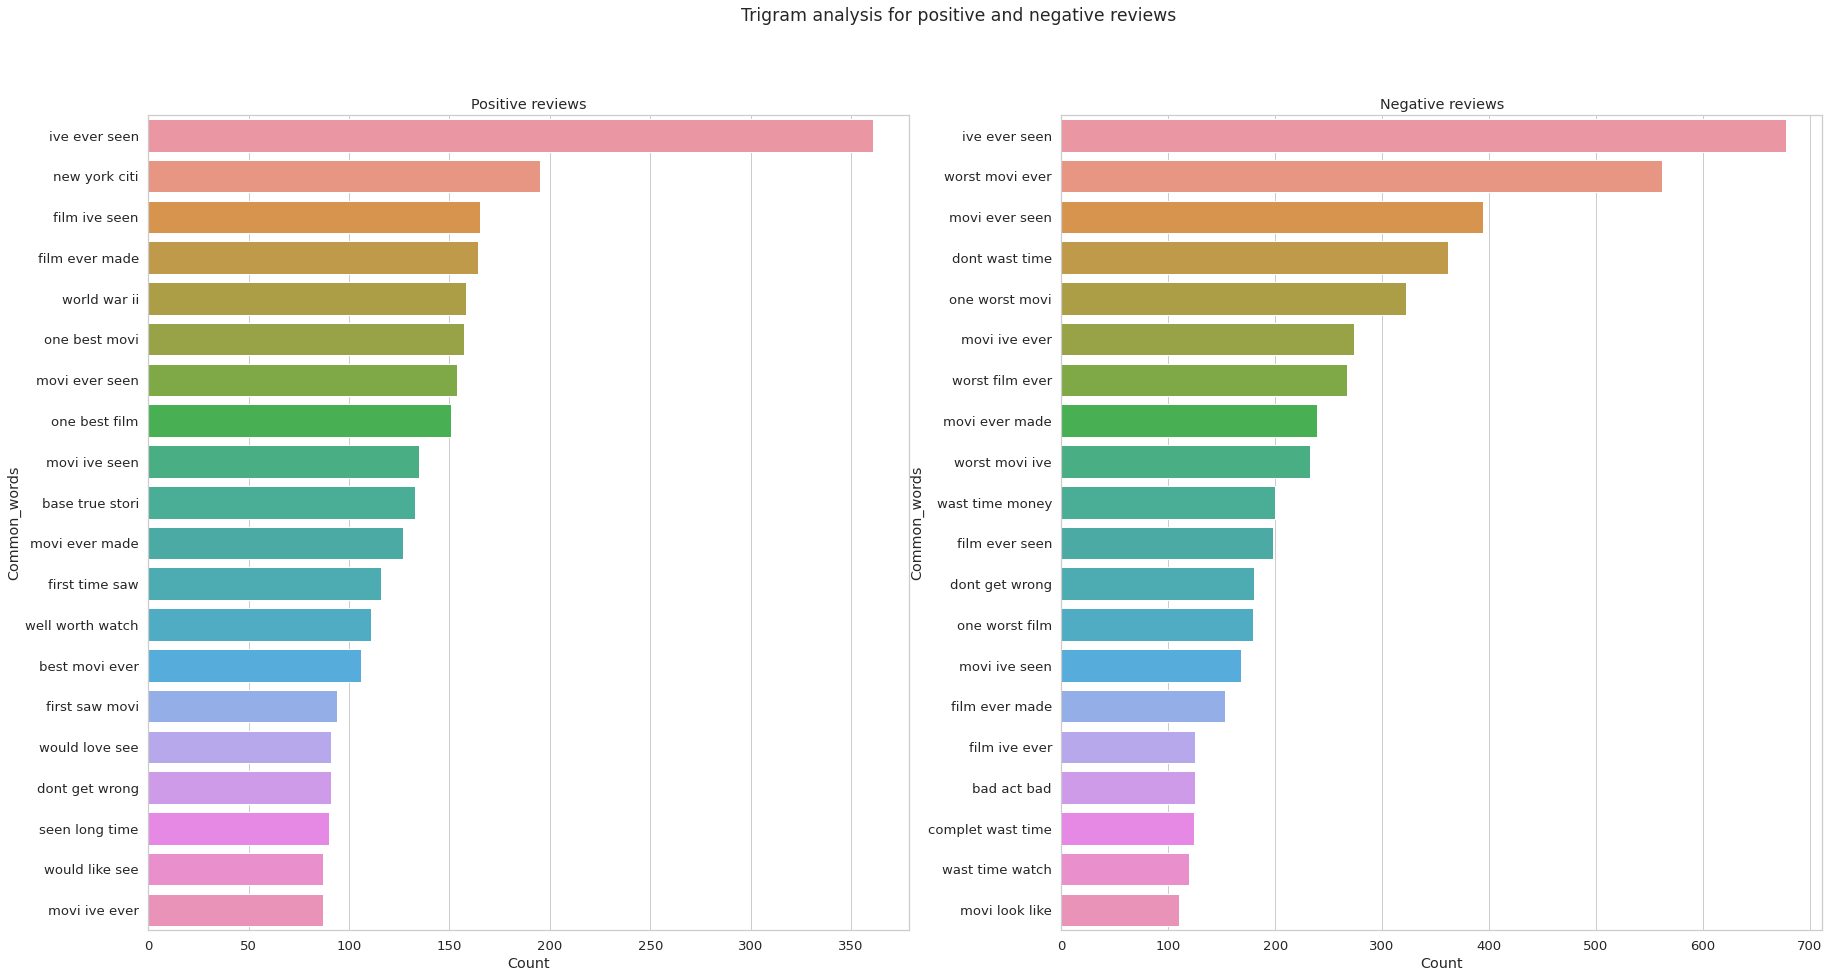

In [32]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(30,15))
tri_positive = get_ngrams(positive_data,20,3)
tri_positive = dict(tri_positive)
temp = pd.DataFrame(list(tri_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('Positive reviews')
tri_negative = get_ngrams(negative_data,20,3)
tri_negative = dict(tri_negative)
temp = pd.DataFrame(list(tri_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('Negative reviews')
fig.suptitle('Trigram analysis for positive and negative reviews')
plt.show()

## LSTM

In [44]:
sentiment = data['sentiment']
data = data['review']

In [45]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data,sentiment,test_size = 0.2, random_state = 42)

In [46]:
tokenizer = Tokenizer(num_words = 15000)
tokenizer.fit_on_texts(data)
#tokenizer.word_index

In [47]:
x_train_tokens = tokenizer.texts_to_sequences(x_train)
x_test_tokens = tokenizer.texts_to_sequences(x_test)

In [48]:
#Then we take the word count of each of our sentences in our data and create a list.
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)

In [49]:
#Here, when setting the number of tokens, a number is determined by taking into account the variability around the average.
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

284

In [50]:
#It is checked what percentage of the data this determined number covers.
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.94548

In [51]:
#data is adjusted according to the number of tokens specified
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens)
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens)

In [52]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

def return_to_sentence(tokens):
    words = [inverse_map[token] for token in tokens if token!=0]
    text = ' '.join(words)
    return text

In [53]:
model = Sequential()

embedding_size = 50

model.add(Embedding(input_dim=15000,output_dim=embedding_size,input_length=max_tokens,name='embedding_layer'))

model.add(LSTM(units=16, return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(units=8, return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(units=4))
model.add(Dropout(0.1))

model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(lr=1e-3)

model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding)  (None, 284, 50)          750000    
                                                                 
 lstm (LSTM)                 (None, 284, 16)           4288      
                                                                 
 dropout (Dropout)           (None, 284, 16)           0         
                                                                 
 lstm_1 (LSTM)               (None, 284, 8)            800       
                                                                 
 dropout_1 (Dropout)         (None, 284, 8)            0         
                                                                 
 lstm_2 (LSTM)               (None, 4)                 208       
                                                                 
 dropout_2 (Dropout)         (None, 4)                 0

In [55]:
history = model.fit(x_train_pad, y_train, validation_split=0.3, epochs=5, batch_size=1000, shuffle=True, verbose = 1)

Epoch 1/5
28/28 [==============================] - 46s 1s/step - loss: 0.6785 - accuracy: 0.6536 - val_loss: 0.6294 - val_accuracy: 0.7603
Epoch 2/5
28/28 [==============================] - 39s 1s/step - loss: 0.5348 - accuracy: 0.8328 - val_loss: 0.5020 - val_accuracy: 0.8274
Epoch 3/5
28/28 [==============================] - 40s 1s/step - loss: 0.4445 - accuracy: 0.8830 - val_loss: 0.4449 - val_accuracy: 0.8508
Epoch 4/5
28/28 [==============================] - 39s 1s/step - loss: 0.3778 - accuracy: 0.9096 - val_loss: 0.4060 - val_accuracy: 0.8651
Epoch 5/5
28/28 [==============================] - 39s 1s/step - loss: 0.3249 - accuracy: 0.9243 - val_loss: 0.3898 - val_accuracy: 0.8617


In [56]:
result = model.evaluate(x_test_pad, y_test)
print(result)

313/313 [==============================] - 19s 52ms/step - loss: 0.3828 - accuracy: 0.8659
[0.38277819752693176, 0.8658999800682068]


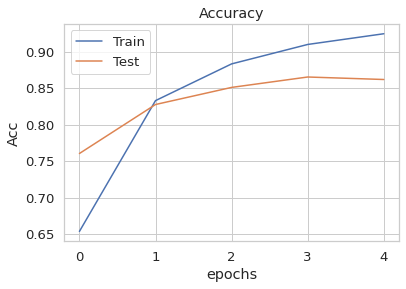

In [58]:
plt.figure()
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

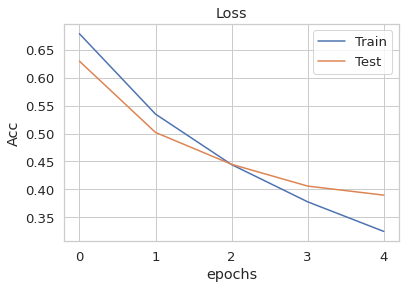

In [59]:
plt.figure()
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

313/313 [==============================] - 18s 57ms/step


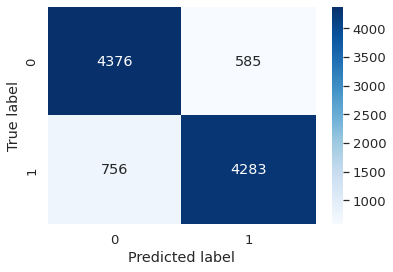

In [76]:
#Generate predictions for the test dataset
ypred = model.predict(x_test_pad)
ypred = ypred>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, ypred)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [60]:
model.save("lstm_model_sentiment.h5")

In [66]:
twt = ['This will not likely be voted best comedy of the year, a few too many coincidences and plot holes. However we are talking about a movie where a hit-man and a white bread salesman become buddies so a few vagaries shouldnt come as too much of a surprise']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=max_tokens)

In [67]:
prediction = model.predict(twt)
print(prediction)
if prediction > 0.5:
    print("Positive sentiment")
else:
    print("Negative sentiment")

1/1 [==============================] - 0s 42ms/step
[[0.79024404]]
Positive sentiment
